In [1]:
import pandas as pd
import numpy as np
import spotipy 
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 
cid ='Enter your CLIENT_ID here' 
secret ='Enter your CLIENT_SECRET here'

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

In [3]:
def playlist_ids(X):
    playlist_uris = []
    for i,ids in enumerate(X["playlists"]['items']):
        playlist_uris.append(ids["uri"])
    return playlist_uris

In [4]:
def songs_database(playlist_uris):
    songs_df = pd.DataFrame()
    for uri in playlist_uris:
        playlist = sp.user_playlist("spotify",uri) 
        songs = playlist["tracks"]["items"] 
        ids = []
        song_names = []
        song_artist = []
        
        for i in range(len(songs)): 
            ids.append(songs[i]["track"]["id"])
            song_names.append(songs[i]["track"]["name"])
            song_artist.append(songs[i]["track"]["artists"][0]['name'])
        features = sp.audio_features(ids)
        df1 = pd.DataFrame()
        for each in features:
            if(each != None):
                d = pd.DataFrame(each,index=[0])
            df1 = df1.append(d,ignore_index=True)
        df2 = pd.DataFrame()
        df2["track_title"] = song_names
        df2["track_artist"] = song_artist
        df2["playlist_name"] = playlist["name"]
        df3 = pd.concat([df2,df1], axis=1)
        
        if songs_df.empty:
            songs_df = df3
        else:
            songs_df = pd.concat([songs_df,df3],axis=0,ignore_index=True)
    
    return songs_df

In [5]:
train_cols = ['danceability','energy', 'key', 'loudness', 'speechiness', 'acousticness',
              'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
target_cols = "genre_class"

In [6]:
# Getting all playlists under "Focus" and "Party" genres
focus = (sp.category_playlists(category_id="focus", country="US", limit=50, offset=0))
classical = (sp.category_playlists(category_id="classical", country="US", limit=50, offset=0))
party = (sp.category_playlists(category_id="party", country="US", limit=50, offset=0))

In [7]:
cats = (sp.categories(country="US", limit=50, offset=0))
categories = []

for each in cats["categories"]["items"]:
    categories.append(each["id"])

In [8]:
focus_uris = playlist_ids(focus)
classical_uris = playlist_ids(classical)
party_uris = playlist_ids(party)

In [9]:
focus_songs = songs_database(focus_uris)
classical_songs = songs_database(classical_uris)

In [10]:
party_songs = songs_database(party_uris)

In [11]:
party_songs[target_cols] = 0
#party_songs
focus_songs[target_cols] = 1
#focus_songs
classical_songs[target_cols] = 2
#classical_songs

In [12]:
complete_songs = pd.concat([party_songs,focus_songs,classical_songs],axis=0)
#complete_songs

In [13]:
complete_songs["genre_class"].value_counts()

1    4034
2    3475
0    2958
Name: genre_class, dtype: int64

In [14]:
genre_labels = {0:"Party",1:"Focus",2:"Classical"}

In [15]:
inv_map = {v: k for k, v in genre_labels.items()}
inv_map

{'Party': 0, 'Focus': 1, 'Classical': 2}

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn import metrics

## Modified K-Means ##
def cluster_centroids(X):
    return((X.mean()))

playlist_clusters = {}
features = complete_songs.sample(frac=1).reset_index(drop=True)
result_cols = ["track_title","track_artist"]
target = features[target_cols]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
y_test = y_test.reset_index(drop=True)

for each in range(3):
    temp = pd.DataFrame()
    temp = X_train[X_train["genre_class"] == each]
    temp2 = pd.DataFrame(scaler.fit_transform(temp[train_cols]))
    k = genre_labels[each]
    playlist_clusters[k] = cluster_centroids(temp2)

playlist_clusters = pd.DataFrame.from_dict(playlist_clusters, orient='index')
playlist_clusters

,0,1,2,3,4,5,6,7,8,9,10
Party,0.647431,0.721982,0.487454,0.681161,0.141446,0.146636,0.093455,0.175393,0.615196,0.420031,0.198150
Focus,0.479020,0.247748,0.459415,0.705783,0.071961,0.746112,0.773610,0.139689,0.260393,0.458933,0.112955
Classical,0.310355,0.140001,0.451498,0.576062,0.082721,0.895969,0.718546,0.112227,0.155550,0.469616,0.069413


In [17]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test[train_cols]))
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,10
0,0.528689,0.4980,0.000000,0.750870,0.040720,0.827309,0.944000,0.203611,0.101324,0.491755,0.083749
1,0.591189,0.3790,0.636364,0.751006,0.050970,0.756024,0.955000,0.126379,0.289206,0.469329,0.040613
2,0.137295,0.0546,0.000000,0.499531,0.079501,0.987952,0.000022,0.111334,0.048778,0.338374,0.099255
3,0.651639,0.6690,0.363636,0.767459,0.052355,0.000123,0.773000,0.253761,0.717923,0.568969,0.108954
4,0.559426,0.7850,0.818182,0.910000,0.077008,0.015161,0.000000,0.760281,0.617108,0.546393,0.022612
...,...,...,...,...,...,...,...,...,...,...,...
2612,0.229508,0.0291,0.636364,0.509750,0.063019,0.962851,0.845000,0.110331,0.054786,0.550503,0.325426
2613,0.357582,0.2790,0.636364,0.706554,0.051385,0.943775,0.861000,0.133400,0.357434,0.539365,0.071290
2614,0.221311,0.0819,0.818182,0.509692,0.061496,0.997992,0.954000,0.093380,0.092770,0.323485,0.031658
2615,0.734631,0.6020,0.909091,0.845774,0.061634,0.810241,0.912000,0.096991,0.352342,0.546056,0.045399


In [18]:
def distances(X):
    X = np.array(X)
    df = pd.DataFrame(index=playlist_clusters.index.copy())
    for index,each in playlist_clusters.iterrows():
        Y = np.array(each)
        distance = np.linalg.norm(X - Y)
        df.loc[index,"distance"] = distance 
    return (df.idxmin(axis = 0)[0])

predictions = []

for index,song in X_test_scaled.iterrows():
    predictions.append(distances(song))
    
predictions = pd.Series(predictions)
predictions = predictions.rename("Assigned_Genre")

print(predictions)

0           Focus
1           Focus
2       Classical
3           Party
4           Party
          ...    
2612    Classical
2613        Focus
2614    Classical
2615        Focus
2616        Party
Name: Assigned_Genre, Length: 2617, dtype: object


In [19]:
y_pred = predictions.map(inv_map)
#y_pred

In [20]:
count=0
for i in range(len(y_pred)):
    if(y_pred[i] == y_test[i]):
        count+=1
acc = count/len(y_pred)
print("Accuracy: ",acc*100)

Accuracy:  68.39893007260221


In [21]:
X_final = X_test[result_cols]
X_final = X_final.reset_index(drop=True)
songs_result = pd.concat([X_final,predictions],axis=1,)
songs_result

,track_title,track_artist,Assigned_Genre
0,The First Surface,Near The Parenthesis,Focus
1,The Imperial March (Darth Vader's Theme),John Williams,Focus
2,"Erbarm dich mein, o Herre Gott, SWV 148",Heinrich Schütz,Classical
3,Spacemodulation,Flug 8,Party
4,bad for you,AKA George,Party
...,...,...,...
2612,"Symphonic Variations on an African Air, Op.63",Samuel Coleridge-Taylor,Classical
2613,"Pomp and Circumstance Marches, Op.39: No.4 - M...",Edward Elgar,Focus
2614,Finding Hope,Haakon Stange,Classical
2615,Torrent (Instrumental Version),Velee,Focus


In [22]:
playlist_clusters.columns = train_cols
polarplot = playlist_clusters.to_dict("index")

for i, key in enumerate(polarplot.keys()):
    if (i>0 and i<3):
        values=list(playlist_clusters.iloc[i])
        print(values)

[0.47902025724919933, 0.2477481758955476, 0.45941504093496205, 0.7057825185739344, 0.07196065812520101, 0.7461120811636351, 0.7736098246836288, 0.13968903683958286, 0.2603926692206918, 0.4589327332541588, 0.1129552293824115]
[0.31035523713093277, 0.1400007854947222, 0.45149763531266524, 0.576062231418674, 0.08272113410894215, 0.8959693122775688, 0.7185456446532358, 0.1122273862419351, 0.15554974682516579, 0.46961584559785347, 0.06941304464940638]


[0.6474312495917429, 0.7219824162664805, 0.487453904120572, 0.6811609399328694, 0.14144554866061596, 0.14663637641003846, 0.09345476315203256, 0.1753925546971267, 0.6151956758120649, 0.42003068195615434, 0.1981503316351411]
[0.47902025724919933, 0.2477481758955476, 0.45941504093496205, 0.7057825185739344, 0.07196065812520101, 0.7461120811636351, 0.7736098246836288, 0.13968903683958286, 0.2603926692206918, 0.4589327332541588, 0.1129552293824115]


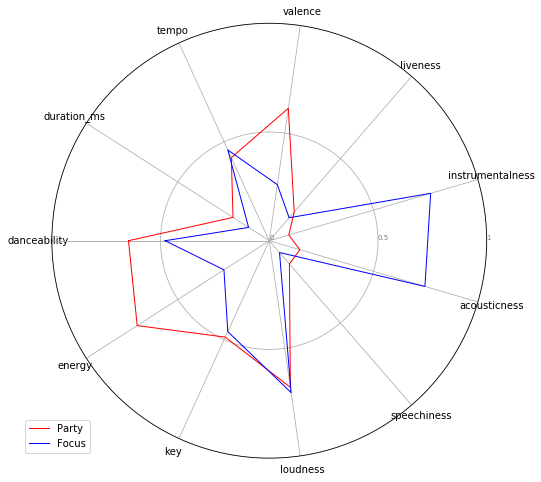

[0.47902025724919933,
 0.2477481758955476,
 0.45941504093496205,
 0.7057825185739344,
 0.07196065812520101,
 0.7461120811636351,
 0.7736098246836288,
 0.13968903683958286,
 0.2603926692206918,
 0.4589327332541588,
 0.1129552293824115,
 0.47902025724919933,
 0.47902025724919933]

In [26]:
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

N = len(train_cols)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi)
ax.set_theta_direction(1)

#ax.spines["polar"].set_visible(False)

plt.xticks(angles, train_cols)

ax.set_rlabel_position(-180)
plt.yticks([0, 0.5, 1], ["0", "0.5","1"], color="grey", size=7)
plt.ylim(0, 1)

# Ind1
colors=['r', 'b', 'y']
for i, key in enumerate(polarplot.keys()):
    if i <2:
        values=list(playlist_clusters.iloc[i])
        print(values)
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=1, linestyle='solid', label=key)
 
# Add legend
plt.legend(bbox_to_anchor=(0.1, 0.1))
plt.show()
fig.savefig("Party vs Focus.png",dpi=300)
values += values[:1]
values